# E2a: Küchentischversuch zum Laval-Rotor

Name: Florian Weiß
Datum: 09.01.2024

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:

Wie verhalten sich Schwingungen, die durch Haushaltsgeräte verursacht werden? Ist der Geschwindigkeitssensor des PIs auschreichend, um diese genau darzustellen?

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="Bild_Handy_Weiss.jpeg" width="500">

- Beschreibung des Aufbaus: Verwendet werden ein vibrierfähiges Smartphone, der Geschwindigkeitssensor und der Raspberry Pi.
- Vorgangsbeschreibung: Der Sensor wird auf dem Smartphone platziert. Anschließend wird die Vibration am Smartphone eingeschaltet.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [1]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [2]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = 'measurement_data' # replace None by the relative path to the first object's folder
h5_file_name = 'data_20240109_140412_FlorianWeiss_Handy.h5' # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

In [3]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240109_140633_FlorianWeiss_mixer/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240109_140633_FlorianWeiss_mixer/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240109_140633_FlorianWeiss_mixer/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeaee62-f57f-6264-a0ef-fc4bc8fc4e7f": {
    "type": "probe",
    "name": "mixer",
    "comment": "",
    "path": "measurement_data/data_2

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [4]:
# get h5 file:
h5_file = h5py.File('measurement_data/data_20240109_140412_FlorianWeiss_Handy/data_20240109_140412_FlorianWeiss_Handy.h5', 'r')

# get uuid for h5 navigation
uuid_sensor = '1eeaee5a-4158-6467-8454-3de37e602842'

# save to numpy arrays
x_acc = np.array(h5_file[uuid_sensor]['acceleration_x'])
y_acc = np.array(h5_file[uuid_sensor]['acceleration_y'])
z_acc = np.array(h5_file[uuid_sensor]['acceleration_z'])
t_measurement = np.array(h5_file[uuid_sensor]['timestamp'])

#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [5]:
from functions import m_postprocessing

# square values
sqx = np.square(x_acc)
sqy = np.square(y_acc)
sqz = np.square(z_acc)

#absolute acceleration is equal to the sqare root of the sum of squares
abs_acc = np.sqrt(sqx+sqy+sqz)

#abs_acc = get_vec_accel(x_acc, y_acc, z_acc) 
# KOMMENTAR: bei mir hat die Ansteuerung über die m_postprocessing-Datei nicht funktioniert, die Ausgaben ergaben immer "None".
#            Also habe ich die Funktionen hier und auch bei 4, 5 und 6 direkt hier im Skript implementiert.
print(abs_acc)

[11.9415203  11.98062822 11.98062822 ... 11.85175747 11.9299177
 11.93165881]


#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

Text(0, 0.5, 'delta t')

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


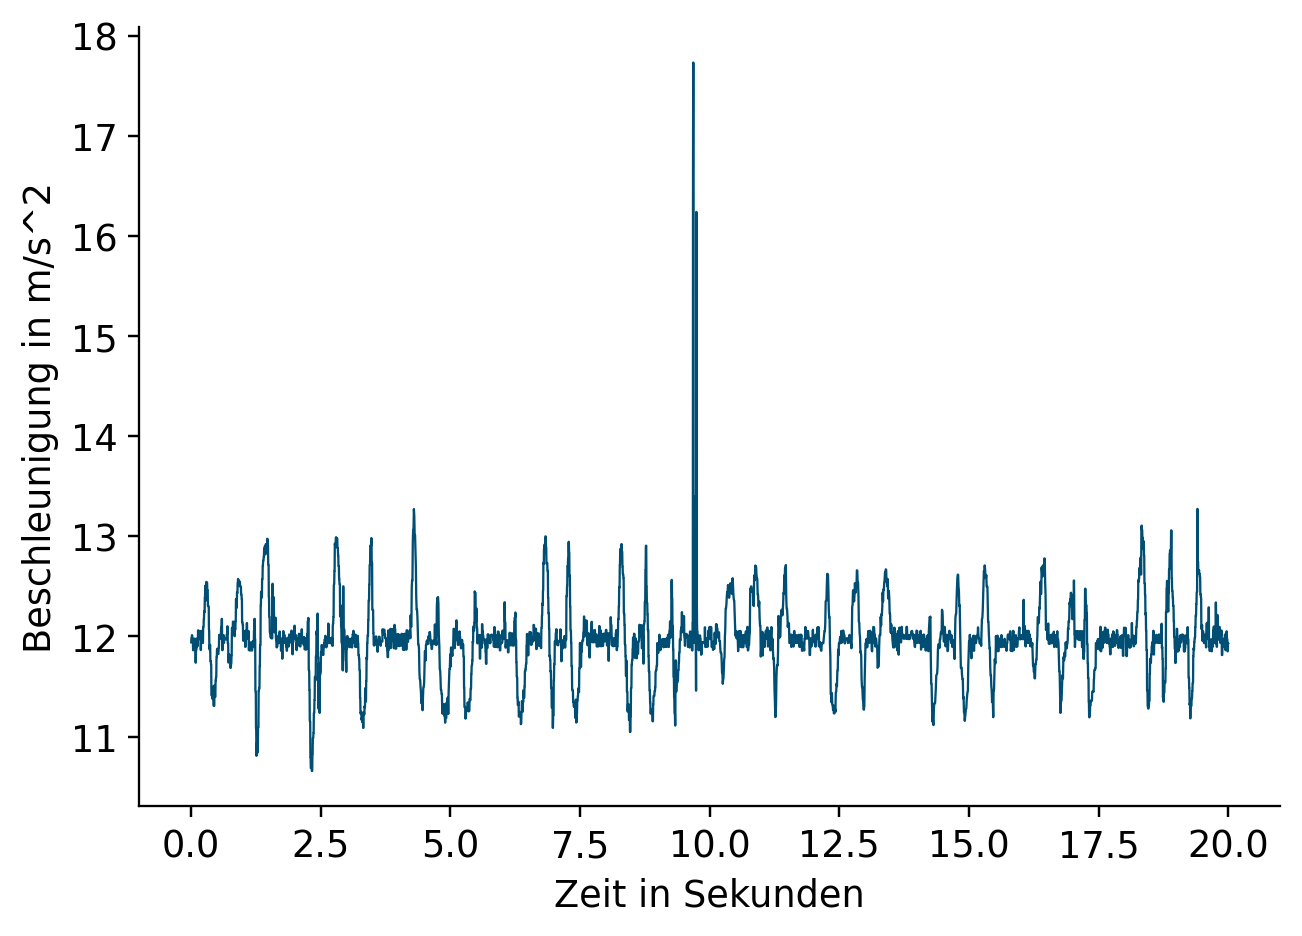

In [6]:
# Erster Plot
figure_1 = plt.figure()
plt.plot(t_measurement, abs_acc) # plottet Beschleunigung über Zeit
plt.xlabel('Zeit in Sekunden')
plt.ylabel('Beschleunigung in m/s^2')

# Zweiter Plot

delta_t = [] # leere liste für die Zeitmessabstände

# nimmt alle zeitabstände undfüllt die liste auf
for i in range(1, (len(t_measurement))):
    delta_t.append(t_measurement[i] - t_measurement[i-1])
    
figure_2 = plt.figure()
plt.plot(delta_t, '.') # plottet Zeitabstände über Schritte
plt.xlabel('Zeitschritte')
plt.ylabel('delta t')

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [7]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.

# creating the time data for the interpolation
t_interpolation = np.linspace(np.min(t_measurement), np.max(t_measurement), len(t_measurement)) 
# interpolation via function
interpolated_data = np.interp(t_interpolation, t_measurement, abs_acc)

# eigentlich sollte funktionieren:
# interpolated_data = interpolation(t_measurement, abs_acc)

#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

Text(0, 0.5, 'Amplitude')

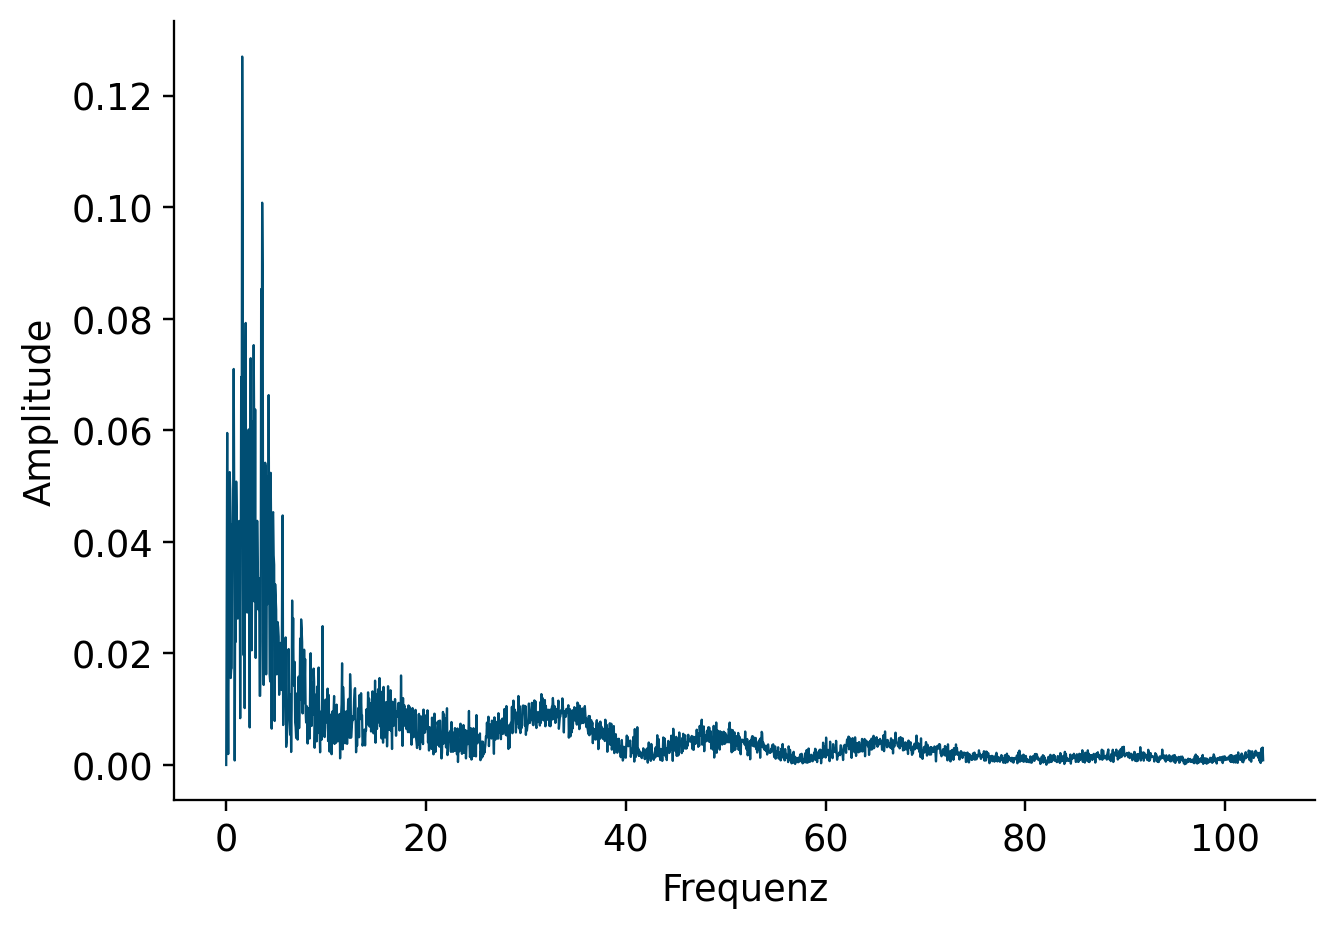

In [8]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.


from numpy.fft import fft

# fft with documention linked in the script

mean = np.mean(interpolated_data)
data_mean = interpolated_data-mean


x = data_mean
sr = len(t_measurement)/(np.max(t_measurement)-np.min(t_measurement))
X = fft(x)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 
n_oneside = N//2
f_oneside = freq[:n_oneside]
X_oneside =X[:n_oneside]/n_oneside

# eigentlich sollte funktionieren:
# X_oneside, f_oneside = my_fft(interpolated_data, t_measurement)

#plot the data
figure_3 = plt.figure()
plt.plot(f_oneside, np.abs(X_oneside))
plt.xlabel('Frequenz')
plt.ylabel('Amplitude')
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="Bild_Mixer_Weiss.jpeg" width="500">

- Beschreibung des Aufbaus:
- Vorgangsbeschreibung:

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [9]:
path_measurement_folder = 'measurement_data' # replace None by the relative path to the first object's folder
h5_file_name = 'data_20240109_140412_FlorianWeiss_mixer.h5' # replace None by the filename of the hdf5-file

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [10]:
# get h5 file:
h5_file = h5py.File('measurement_data/data_20240109_140633_FlorianWeiss_mixer/data_20240109_140633_FlorianWeiss_mixer.h5', 'r')

# get uuid for h5 navigation
uuid_sensor = '1eeaee62-f57f-6264-a0ef-fc4bc8fc4e7f'

# save to numpy arrays
x_acc = np.array(h5_file[uuid_sensor]['acceleration_x'])
y_acc = np.array(h5_file[uuid_sensor]['acceleration_y'])
z_acc = np.array(h5_file[uuid_sensor]['acceleration_z'])
t_measurement = np.array(h5_file[uuid_sensor]['timestamp'])

#### 2. Betrag der Beschleunigung berechnen


In [11]:
from functions import m_postprocessing
sqx = np.square(x_acc)
sqy = np.square(y_acc)
sqz = np.square(z_acc)

abs_acc = np.sqrt(sqx+sqy+sqz)

#abs_acc = get_vec_accel(x_acc, y_acc, z_acc) 
print(abs_acc)

[12.36565292 12.36565292 11.8088355  ... 13.90952226 13.69098255
 12.68772841]


#### 3. Darstellung der Messdaten

Text(0, 0.5, 'delta t')

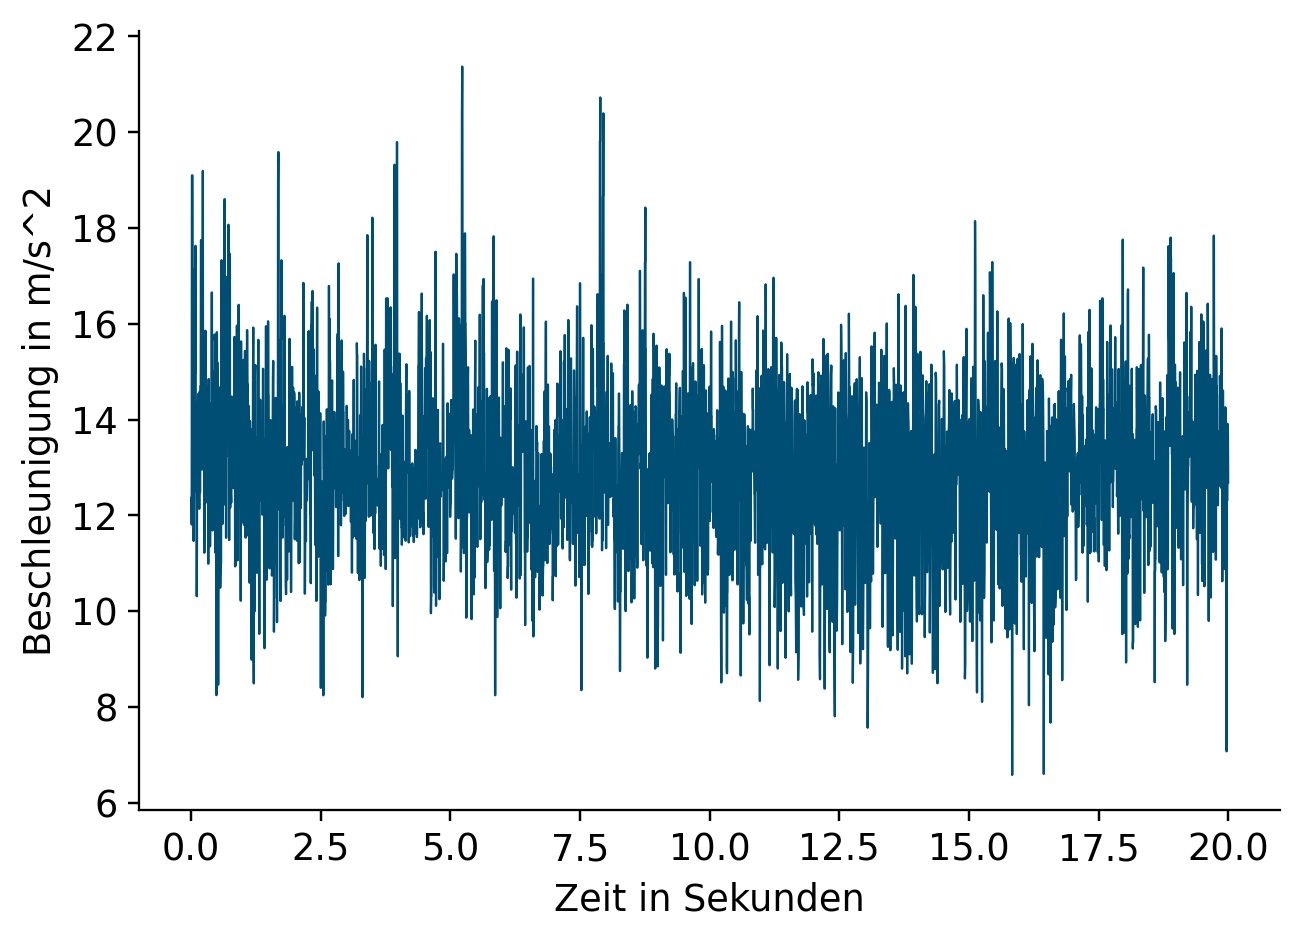

In [12]:
# Erster Plot
figure_1 = plt.figure()
plt.plot(t_measurement, abs_acc) # plottet Beschleunigung über Zeit
plt.xlabel('Zeit in Sekunden')
plt.ylabel('Beschleunigung in m/s^2')

# Zweiter Plot

delta_t = [] # leere liste für die Zeitmessabstände

# nimmt alle zeitabstände undfüllt die liste auf
for i in range(1, (len(t_measurement))):
    delta_t.append(t_measurement[i] - t_measurement[i-1])
    
figure_2 = plt.figure()
plt.plot(delta_t, '.') # plottet Zeitabstände über Schritte
plt.xlabel('Zeitschritte')
plt.ylabel('delta t')

#### 4. Interpolation der Messwerte



In [13]:
t_interpolation = np.linspace(np.min(t_measurement), np.max(t_measurement), len(t_measurement)) 
interpolated_data = np.interp(t_interpolation, t_measurement, abs_acc)

#### 5 & 6. FFT durchführen und graphisch darstellen


In [14]:
from numpy.fft import fft
#
mean = np.mean(interpolated_data)
data_mean = interpolated_data-mean
x = data_mean
sr = len(t_measurement)/(np.max(t_measurement)-np.min(t_measurement))
X = fft(x)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 
n_oneside = N//2
f_oneside = freq[:n_oneside]
X_oneside =X[:n_oneside]/n_oneside

figure_3 = plt.figure()
plt.plot(f_oneside, np.abs(X_oneside))
plt.xlabel('Frequenz')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Aus den Graphen der absoluten Beschleunigungen lässt sich herauslesen, dass die Amplitude an Beschleunigung bei der Handyvibration viel kleiner ist als beim Mixer. Die des Handys liegt etwa bei 1.5 m/s^2, während die des Mixers etwa 6 m/s^2 beträgt. Beim Handy liegt außerdem eine kurzzeitige, sehr hohe Beschleunigung bei etwa 9.5 Sekunden vor, die wahrscheinlich auf einen Messfehler zurückzuführen ist. Hier hat sich der Sensor vermutlich übermäßig auf dem Handy bewegt und spiegelt an diesezm Zeitpunkt so nicht die reale Schwingung des Handys wieder.

Außerdem ist auffällig, dass die Messabstände des Pis teilweise sehr unterschiedlich sind. Im Bereich um 1200 Zeitschritte und zwischen 2800 und 3500 Zeitschritten liegen die Abstände deutlich höher, was die Daten verfälschen könnte. Allerdings ist in den Beschleunigungswerten keine klare Auswirkung davon zu erkennen, weshalb sich die höheren Messabschnitte wahrscheinlich nicht negativ auf die Messungen ausgewirkt haben. Der Pi ist somit immernoch geeignet für eine solche Art der Messung.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Insgesamt finde ich es sehr spannend zu sehen, wie verschieden die von einem Handy und einem Mixer hervorgerufenen Vibrationen sind. Die des Handys haben nur sehr wenig Varianz in der Gesamtbeschleunigung ist sind sehr klar erkennbar, während die des Mixers eine große Bandbreite an Beschleunigungen des Sensors bewirken.

Dieser Versuch hat durchaus Spaß gemacht, da die Programmierarbeit nicht übermäßig viel war und die Versuchsdurchführung nicht riesig viel Aufbau benötigte.